In [1]:
import torch
import torch.nn as nn


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input channel, 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 6 input channels, 6 output channels, 5x5 kernel
        self.pool1 = nn.MaxPool2d(2, 2)

        # 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 16 input channels, 16 output channels, 5x5 kernel
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)  # input shape: (batch_size, 1, 28, 28)
        x = torch.relu(x)  # output shape: (batch_size, 6, 24, 24)
        x = self.pool1(x)  # output shape: (batch_size, 6, 12, 12)

        x = self.conv2(x)  # input shape: (batch_size, 6, 12, 12)
        x = torch.relu(x)  # output shape: (batch_size, 16, 8, 8)
        x = self.pool2(x)  # output shape: (batch_size, 16, 4, 4)

        x = x.view(x.shape[0], -1)  # output shape: (batch_size, 16*4*4)
        x = self.fc1(x)  # output shape: (batch_size, 120)
        x = torch.relu(x)
        x = self.fc2(x)  # output shape: (batch_size, 84)
        x = torch.relu(x)
        x = self.fc3(x)  # output shape: (batch_size, 10)

        return x


def print_params(model):
    count = 0
    for name, param in model.named_parameters():
        count += param.numel()
        print(name, param.shape)
    print('total parameters:', count)


def print_forward(model, x):
    print('input x to model:', x.shape)
    for name, layer in model.named_children():
        if name == 'fc1':
            x = x.view(x.shape[0], -1)
        x = layer(x)
        print(f'{name} after size: {x.shape}')


# model = LeNet()
# print(model)
# print('---')
# print_params(model)

# x = torch.randn(64, 1, 28, 28)
# print_forward(model, x)

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random

# 设置全局随机种子
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def worker_init_fn(worker_id):
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)


transform = transforms.Compose([
    transforms.RandomRotation(12),  # 随机旋转 12 度
    transforms.ToTensor()
])

# 加载训练数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)


# 定义训练数据加载器
train_loader = DataLoader(
    dataset=train_dataset, batch_size=64, shuffle=True, worker_init_fn=worker_init_fn)

In [7]:
learning_rate = 0.001
model = LeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [8]:
# import wandb
# wandb.require("core")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion.to(device)

epochs = 100
for epoch in range(epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        if (i + 1) % 100 == 0:
            # wandb.log({"loss": loss.item(), "acc": acc.item()})
            print(
                f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')


# wandb.finish()

Epoch [1/10], Step [100/938], Loss: 0.5883
Epoch [1/10], Step [200/938], Loss: 0.2123
Epoch [1/10], Step [300/938], Loss: 0.2067
Epoch [1/10], Step [400/938], Loss: 0.0995
Epoch [1/10], Step [500/938], Loss: 0.0600
Epoch [1/10], Step [600/938], Loss: 0.4117
Epoch [1/10], Step [700/938], Loss: 0.1972
Epoch [1/10], Step [800/938], Loss: 0.1171
Epoch [1/10], Step [900/938], Loss: 0.1093
Epoch [2/10], Step [100/938], Loss: 0.0774
Epoch [2/10], Step [200/938], Loss: 0.1095
Epoch [2/10], Step [300/938], Loss: 0.1426
Epoch [2/10], Step [400/938], Loss: 0.2485
Epoch [2/10], Step [500/938], Loss: 0.0515
Epoch [2/10], Step [600/938], Loss: 0.0684
Epoch [2/10], Step [700/938], Loss: 0.0508
Epoch [2/10], Step [800/938], Loss: 0.0224
Epoch [2/10], Step [900/938], Loss: 0.0719
Epoch [3/10], Step [100/938], Loss: 0.1992
Epoch [3/10], Step [200/938], Loss: 0.0292
Epoch [3/10], Step [300/938], Loss: 0.0971
Epoch [3/10], Step [400/938], Loss: 0.2116
Epoch [3/10], Step [500/938], Loss: 0.0951
Epoch [3/10

{0: 5, 1: 5, 2: 5, 3: 11, 4: 7, 5: 14, 6: 10, 7: 8, 8: 15, 9: 20}
error-count: 100
Accuracy of the network on the 10000 test images: 99.00%


<BarContainer object of 10 artists>

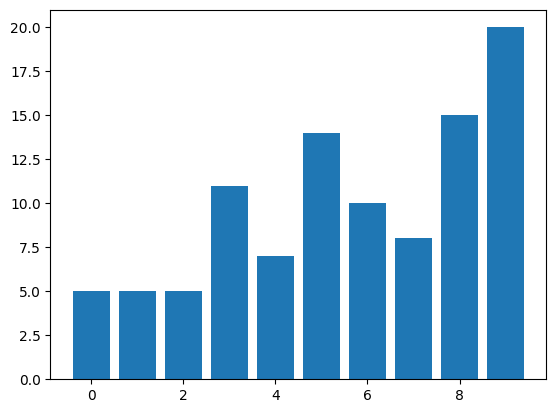

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint


# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(
    dataset=test_dataset, batch_size=64, shuffle=False)

# 测试模型
model.eval()  # 切换到评估模式
with torch.no_grad():
    """ 统计每个数字的错误次数 """
    error_count_dict = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 0,
        8: 0,
        9: 0
    }
    test_loss = 0.0
    correct = 0
    total = 0

    for batch_index, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        error_index = np.where((predicted == labels).cpu().numpy() == False)[0]
        for index in error_index:
            error_count_dict[labels[index].item()] += 1

test_loss /= total
test_accuracy = correct / total

pprint(error_count_dict)
print('error-count:', sum(error_count_dict.values()))
print('Accuracy of the network on the 10000 test images: {:.2f}%'.format(
    100 * test_accuracy))

# 将每个数字的错误次数绘制为柱状图
plt.bar(error_count_dict.keys(), error_count_dict.values())

In [15]:
# 保存后加载模型
torch.save(model.state_dict(), './model.pth')

# model = Net()
# model.load_state_dict(torch.load('./server/model.pth'))

# # 创建一个示例输入张量（假设输入尺寸是 [1, 784]）
# dummy_input = torch.randn(1, 28 * 28)

# # 导出模型到 ONNX 格式
# torch.onnx.export(
#     model,                # 要转换的模型
#     dummy_input,          # 示例输入张量
#     "model.onnx",         # 导出的 ONNX 文件名
#     input_names=['input'],  # 输入张量的名称
#     output_names=['output'],  # 输出张量的名称
#     opset_version=11      # ONNX opset 版本，通常使用最新版本（这里使用 11）
# )